# E02. Evaluate Players
- This evaluates player projections
- Type: Evaluation
- Run Frequency: Irregular
- Sources:
    - Daily Fantasy Fuel
    - Player Results (MLB API)
- Created: 3/30/2024
- Updated: 8/5/2025

### Imports

In [1]:
%run "C:\Users\james\Documents\MLB\Code\U1. Imports.ipynb"
%run "C:\Users\james\Documents\MLB\Code\U2. Functions.ipynb"
%run "C:\Users\james\Documents\MLB\Code\U3. Classes.ipynb"

### Dates

In [2]:
start_date, end_date = "20240101", "20240930"
start_date, end_date = "20240101", "20240524"
# start_date, end_date = todaysdate, todaysdate

### Games

Games played

In [3]:
%%time
historic_game_df = pd.read_csv(os.path.join(baseball_path, "game_df.csv"))
recent_game_df = create_games(yesterdaysdate, todaysdate, team_dict)
historic_game_df = historic_game_df[~historic_game_df['date'].astype(str).isin([yesterdaysdate, todaysdate])]
all_game_df = pd.concat([historic_game_df, recent_game_df], axis=0)
all_game_df.to_csv(os.path.join(baseball_path, "game_df.csv"), index=False)

CPU times: total: 188 ms
Wall time: 315 ms


In [4]:
game_df = all_game_df[(all_game_df['date'].astype(str) >= start_date) & (all_game_df['date'].astype(str) <= end_date)].reset_index(drop=True)

Dates and games with my projections

In [5]:
date_mask = (game_df['date'].astype(str) >= start_date) & (game_df['date'].astype(str) <= end_date) 
date_list = list(game_df[date_mask]['date'].unique())
date_folders = [f"Matchups {date}" for date in date_list]
date_folders = [date_folder for date_folder in os.listdir(r"C:\Users\james\Documents\MLB\Database\B02. Simulations\2. Player Sims") and date_folders]

game_list = list(game_df[date_mask]['game_id'].unique())
player_folders = [f"Players {game}" for game in game_list]

### Functions

Extract date, teams, and gamePk from folder names

In [6]:
def extract_info_from_folder(date_folder, matchup_folder):
    # Extract date from date folder
    date = date_folder.split(' ')[1]
    
    # Extract teams and gamePK from matchup folder
    parts = matchup_folder.split(' ')
    away_team, home_team = parts[0].split('@')
    gamePk = parts[1]
    
    return date, away_team, home_team, gamePk

Average player stats for a given position group

In [7]:
def game_averages(date_folder, matchup_folder, position='pitchers'):
    date, away_team, home_team, gamePk = extract_info_from_folder(date_folder, matchup_folder)
    
    # Initialize an empty list to store DataFrames
    dfs = []
    
    # Get a list of all CSV files in the matchup folder
    csv_files = [file for file in os.listdir(os.path.join(baseball_path, "B02. Simulations", "2. Player Sims", date_folder, matchup_folder)) 
                 if file.startswith(position) and file.endswith('.csv')]
    
    # Iterate over each CSV file
    for csv_file in csv_files:
        # Read the CSV file into a DataFrame
        df = pd.read_csv(os.path.join(baseball_path, "B02. Simulations", "2. Player Sims", date_folder, matchup_folder, csv_file))
        
        # Append date, away_team, home_team, and gamePk columns
        df['date'] = date
        df['away_team'] = away_team
        df['home_team'] = home_team
        df['gamePk'] = gamePk
        
        # Append the DataFrame to the list
        dfs.append(df)
    
    # Concatenate all DataFrames in the list
    combined_df = pd.concat(dfs)
    
    # Select numeric columns
    numeric_cols = combined_df.select_dtypes(include='number')
    
    # Group by fullName and calculate the mean for numeric columns
    averaged_numeric_cols = numeric_cols.groupby(combined_df['fullName'], sort=False).mean()
    
    # Select team and additional columns
    additional_cols = combined_df[['fullName', 'team', 'date', 'away_team', 'home_team', 'gamePk']].drop_duplicates('fullName').set_index('fullName')
    
    # Concatenate numeric and additional columns
    averaged_df = pd.concat([additional_cols, averaged_numeric_cols], axis=1).reset_index()

    averaged_df['team_abbrev'] = np.where(averaged_df['team'] == "away", averaged_df['away_team'], averaged_df['home_team'])

    averaged_df['starter'] = (~averaged_df['team'].duplicated()).astype(int)

    return averaged_df

### Player Sim Files

Calculate averages for player stats in simulations by game

##### Batters

Calculate averages

In [8]:
%%time
position = 'batters'

# Parallelize the loop using joblib and directly return df_list
batter_df_list = Parallel(n_jobs=-1)(
    delayed(game_averages)(date_folder, matchup_folder, position) 
    for date_folder in date_folders 
    for matchup_folder in os.listdir(os.path.join(baseball_path, "B02. Simulations", "2. Player Sims", date_folder)))

CPU times: total: 14.3 s
Wall time: 19min 7s


Write to CSV

In [9]:
for df in batter_df_list:
    gamePk = df['gamePk'][0]
    away_df = df.query('team == "away"')
    home_df = df.query('team == "home"')
    
    # Create folder
    os.makedirs(os.path.join(baseball_path, "C04. Players", f"Players {gamePk}"), exist_ok=True)

    # Write to csv
    away_df.to_csv(os.path.join(baseball_path, "C04. Players", f"Players {gamePk}", f"away batters projections {gamePk}.csv"), index=False)
    home_df.to_csv(os.path.join(baseball_path, "C04. Players", f"Players {gamePk}", f"home batters projections {gamePk}.csv"), index=False)

##### Pitchers

Calculate averages

In [10]:
%%time
position = 'pitchers'

# Parallelize the loop using joblib and directly return df_list
pitcher_df_list = Parallel(n_jobs=-1)(
    delayed(game_averages)(date_folder, matchup_folder, position) 
    for date_folder in date_folders 
    for matchup_folder in os.listdir(os.path.join(baseball_path, "B02. Simulations", "2. Player Sims", date_folder)))

CPU times: total: 12.4 s
Wall time: 18min 6s


Write to CSV

In [11]:
for df in pitcher_df_list:
    gamePk = df['gamePk'][0]
    away_df = df.query('team == "away"')
    home_df = df.query('team == "home"')
    
    # Create folder
    os.makedirs(os.path.join(baseball_path, "C04. Players", f"Players {gamePk}"), exist_ok=True)

    # Write to csv
    away_df.to_csv(os.path.join(baseball_path, "C04. Players", f"Players {gamePk}", f"away pitchers projections {gamePk}.csv"), index=False)
    home_df.to_csv(os.path.join(baseball_path, "C04. Players", f"Players {gamePk}", f"home pitchers projections {gamePk}.csv"), index=False)

### Player Scoring

Add players' actual scoring onto simulated projections

##### Batters

In [12]:
# Define a function to process each folder
def process_batters(folder):
    # Extract gamePk
    gamePk = folder.split(" ")[1]

    ### Batters
    ## Away
    # Read in projections
    away_batter_projected_results_df = pd.read_csv(os.path.join(baseball_path, "C04. Players", f"Players {gamePk}", f"away batters projections {gamePk}.csv"))
    # Read in results
    away_batter_actual_results_df = pd.read_csv(os.path.join(baseball_path, "A10. Player Results", f"Player Results {gamePk}", f"away batters {gamePk}.csv"))

    # Merge
    away_batters_merged = away_batter_projected_results_df[['fullName', 'id', 'imp_b_l', 'imp_b_r', 'PA', 'HBP', 'BB', 'B1', 'B2', 'B3', 'HR', 'SB', 'R', 'RBI', 'FP', 'gamePk']].merge(away_batter_actual_results_df, left_on=['id', 'gamePk'], right_on=['personId', 'gamePk'], how='outer')

    ## Home
    # Read in projections
    home_batter_projected_results_df = pd.read_csv(os.path.join(baseball_path, "C04. Players", f"Players {gamePk}", f"home batters projections {gamePk}.csv"))
    # Read in results
    home_batter_actual_results_df = pd.read_csv(os.path.join(baseball_path, "A10. Player Results", f"Player Results {gamePk}", f"home batters {gamePk}.csv"))

    # Merge
    home_batters_merged = home_batter_projected_results_df[['fullName', 'id', 'imp_b_l', 'imp_b_r', 'PA', 'HBP', 'BB', 'B1', 'B2', 'B3', 'HR', 'SB', 'R', 'RBI', 'FP', 'gamePk']].merge(home_batter_actual_results_df, left_on=['id', 'gamePk'], right_on=['personId', 'gamePk'], how='outer')

    # Append them together
    batters_merged = pd.concat([away_batters_merged, home_batters_merged], axis=0)

    
    return batters_merged

In [13]:
def process_batters2(folder):
    try:
        batters_merged = process_batters(folder)    
        return batters_merged   
    except:
        pass 

In [14]:
%%time
# Run the loop in parallel
batters_merged_list = Parallel(n_jobs=-1)(delayed(process_batters2)(folder) for folder in player_folders)
batters_merged_df = pd.concat(batters_merged_list, axis=0)

CPU times: total: 3.42 s
Wall time: 4.79 s


##### Pitchers

In [15]:
def process_pitchers(folder):
    # Extract gamePk
    gamePk = folder.split(" ")[1]
    
    ### Pitchers
    ## Away
    # Read in projections
    away_pitcher_projected_results_df = pd.read_csv(os.path.join(baseball_path, "C04. Players", f"Players {gamePk}", f"away pitchers projections {gamePk}.csv"))
    away_pitcher_projected_results_df['team'] = "away"
    # Read in results
    away_pitcher_actual_results_df = pd.read_csv(os.path.join(baseball_path, "A10. Player Results", f"Player Results {gamePk}", f"away pitchers {gamePk}.csv"))

    # Merge
    away_pitchers_merged = away_pitcher_projected_results_df[['fullName', 'id', 'imp_p_l', 'imp_p_r', 'OUT', 'PA', 'SO', 'HBP', 'BB', 'B1', 'B2', 'B3', 'HR', 'H', 'R', 'ER', 'W', 'CG', 'CGSO', 'NH', 'FP', 'team', 'gamePk']].merge(away_pitcher_actual_results_df, left_on=['id', 'gamePk', 'team'], right_on=['personId', 'gamePk', 'team'], how='outer')
    
    ## Home
    # Read in projections
    home_pitcher_projected_results_df = pd.read_csv(os.path.join(baseball_path, "C04. Players", f"Players {gamePk}", f"home pitchers projections {gamePk}.csv"))
    home_pitcher_projected_results_df['team'] = "home"
    # Read in results
    home_pitcher_actual_results_df = pd.read_csv(os.path.join(baseball_path, "A10. Player Results", f"Player Results {gamePk}", f"home pitchers {gamePk}.csv"))

    # Merge
    home_pitchers_merged = home_pitcher_projected_results_df[['fullName', 'id', 'imp_p_l', 'imp_p_r', 'OUT', 'PA', 'SO', 'HBP', 'BB', 'B1', 'B2', 'B3', 'HR', 'H', 'R', 'ER', 'W', 'CG', 'CGSO', 'NH', 'FP', 'team', 'gamePk']].merge(home_pitcher_actual_results_df, left_on=['id', 'gamePk', 'team'], right_on=['personId', 'gamePk', 'team'], how='outer')

    # Append them together
    pitchers_merged = pd.concat([away_pitchers_merged, home_pitchers_merged], axis=0)

    
    return pitchers_merged

In [16]:
def process_pitchers2(folder):
    try:
        pitchers_merged = process_pitchers(folder)    
        return pitchers_merged   
    except:
        pass 

In [17]:
%%time
# Run the loop in parallel
pitchers_merged_list = Parallel(n_jobs=-1)(delayed(process_pitchers2)(folder) for folder in player_folders)
pitchers_merged_df = pd.concat(pitchers_merged_list, axis=0)

CPU times: total: 3.58 s
Wall time: 5.19 s


### 1. Player Stat Evaluations

File path

In [18]:
player_stat_path = os.path.join(baseball_path, "C02. Players", "1. Player Stat Evaluations", f"Player Stat Evaluations {todaysdate}.xlsx")

##### Batters

Create New Variables

In [19]:
# Actual singles
batters_merged_df['singles'] = batters_merged_df['h'] - batters_merged_df['doubles'] - batters_merged_df['triples'] - batters_merged_df['hr']
# Actual PA
batters_merged_df['pa'] = batters_merged_df[['ab', 'bb', 'hbp']].sum(axis=1)
# Projected hits
batters_merged_df['H'] = batters_merged_df[['B1', 'B2', 'B3', 'HR']].sum(axis=1)
# Reached
batters_merged_df['ON'] = batters_merged_df[['H', 'BB', 'HBP']].sum(axis=1)
batters_merged_df['on'] = batters_merged_df[['h', 'bb', 'hbp']].sum(axis=1)

In [20]:
# Identify number of batters that batted in a given spot in the order (we may only want those who were never subbed out or are subs)
batters_merged_df['battingSpot'] = batters_merged_df['battingOrder'] // 100
# Instance of batter in that spot
# Example:
# Three batters batted 4
# All three would have battingSpot = 4
# battingSpotInstance for starter would be 1, the first sub would be 2, second sub would be 3
batters_merged_df['battingSpotInstance'] = batters_merged_df.groupby(['gamePk', 'team', 'battingSpot'])['battingSpot'].transform('count')

##### Figure 1A. Unimputed Starting Batters

In [21]:
unimputed_batters = batters_merged_df.query('battingSpotInstance == 1').query('imp_b_l == 0 & imp_b_r == 0')[['PA', 'pa', 'ON', 'on', 'H', 'h', 'B1', 'singles', 'B2', 'doubles', 'B3', 'triples', 'HR', 'hr', 'BB', 'bb', 'SB', 'sb', 'FP', 'fp']].agg(['mean', 'sum'])

# Split the dataframe into projected (even rows) and actual (odd rows)
projected = unimputed_batters.T.iloc[::2].reset_index()
actual = unimputed_batters.T.iloc[1::2].reset_index()

# Concatenate the two dataframes side-by-side
unimputed_batters = pd.concat([projected, actual], axis=1)

# Rename the columns
unimputed_batters.columns = ["Projected", "Projected Mean", 'Projected Sum', "Actual", "Actual Mean", 'Actual Sum']

# Set Projected Share
unimputed_batters['Projected Share'] = 0.0
unimputed_batters.loc[unimputed_batters['Projected'] == 'PA', 'Projected Share'] = 1
unimputed_batters.loc[unimputed_batters['Projected'] == 'ON', 'Projected Share'] = (
    unimputed_batters.loc[unimputed_batters['Projected'] == 'ON', 'Projected Mean'].values[0] / unimputed_batters.loc[unimputed_batters['Projected'] == 'PA', 'Projected Mean'].values[0])
unimputed_batters.loc[~unimputed_batters['Projected'].isin(['PA', 'ON']), 'Projected Share'] = (
    unimputed_batters.loc[~unimputed_batters['Projected'].isin(['PA', 'ON']), 'Projected Mean'] / unimputed_batters.loc[unimputed_batters['Projected'] == 'PA', 'Projected Mean'].values[0])

# Set Actual Share
unimputed_batters['Actual Share'] = 0.0
unimputed_batters.loc[unimputed_batters['Actual'] == 'pa', 'Actual Share'] = 1
unimputed_batters.loc[unimputed_batters['Actual'] == 'on', 'Actual Share'] = (
    unimputed_batters.loc[unimputed_batters['Actual'] == 'on', 'Actual Mean'].values[0] / unimputed_batters.loc[unimputed_batters['Actual'] == 'pa', 'Actual Mean'].values[0]
)
unimputed_batters.loc[~unimputed_batters['Actual'].isin(['pa', 'on']), 'Actual Share'] = (
    unimputed_batters.loc[~unimputed_batters['Actual'].isin(['pa', 'on']), 'Actual Mean'] / unimputed_batters.loc[unimputed_batters['Actual'] == 'pa', 'Actual Mean'].values[0])

# Rename
unimputed_batters.rename(columns={'Projected': 'Stat'}, inplace=True)

# Cut
unimputed_batters = unimputed_batters[['Stat', 'Projected Mean', 'Actual Mean', 'Projected Share', 'Actual Share']].round(4)
unimputed_batters

,Stat,Projected Mean,Actual Mean,Projected Share,Actual Share
0,PA,4.226600,4.148400,1.000000,1.000000
1,ON,1.331300,1.306400,0.315000,0.314900
2,H,0.935000,0.910000,0.221200,0.219400
3,B1,0.596100,0.597100,0.141000,0.143900
4,B2,0.198200,0.175600,0.046900,0.042300
5,B3,0.016900,0.015000,0.004000,0.003600
6,HR,0.123800,0.122200,0.029300,0.029500
7,BB,0.350300,0.352400,0.082900,0.084900
8,SB,0.082600,0.083100,0.019500,0.020000
9,FP,7.304700,7.125900,1.728300,1.717700


Write to Excel

In [22]:
with pd.ExcelWriter(player_stat_path, engine='openpyxl', mode='w') as writer:
    unimputed_batters.to_excel(writer, sheet_name='UnimputedBatters', index=False)

##### Figure 1B. Imputed Starting Batters

In [23]:
imputed_batters = batters_merged_df.query('battingSpotInstance == 1').query('imp_b_l == 1 | imp_b_r == 1')[['PA', 'pa', 'ON', 'on', 'H', 'h', 'B1', 'singles', 'B2', 'doubles', 'B3', 'triples', 'HR', 'hr', 'BB', 'bb', 'SB', 'sb', 'FP', 'fp']].agg(['mean', 'sum'])

# Split the dataframe into projected (even rows) and actual (odd rows)
projected = imputed_batters.T.iloc[::2].reset_index()
actual = imputed_batters.T.iloc[1::2].reset_index()

# Concatenate the two dataframes side-by-side
imputed_batters = pd.concat([projected, actual], axis=1)

# Rename the columns
imputed_batters.columns = ["Projected", "Projected Mean", 'Projected Sum', "Actual", "Actual Mean", 'Actual Sum']

# Set Projected Share
imputed_batters['Projected Share'] = 0.0
imputed_batters.loc[imputed_batters['Projected'] == 'PA', 'Projected Share'] = 1
imputed_batters.loc[imputed_batters['Projected'] == 'ON', 'Projected Share'] = (
    imputed_batters.loc[imputed_batters['Projected'] == 'ON', 'Projected Mean'].values[0] / imputed_batters.loc[imputed_batters['Projected'] == 'PA', 'Projected Mean'].values[0])
imputed_batters.loc[~imputed_batters['Projected'].isin(['PA', 'ON']), 'Projected Share'] = (
    imputed_batters.loc[~imputed_batters['Projected'].isin(['PA', 'ON']), 'Projected Mean'] / imputed_batters.loc[imputed_batters['Projected'] == 'PA', 'Projected Mean'].values[0])

# Set Actual Share
imputed_batters['Actual Share'] = 0.0
imputed_batters.loc[imputed_batters['Actual'] == 'pa', 'Actual Share'] = 1
imputed_batters.loc[imputed_batters['Actual'] == 'on', 'Actual Share'] = (
    imputed_batters.loc[imputed_batters['Actual'] == 'on', 'Actual Mean'].values[0] / imputed_batters.loc[imputed_batters['Actual'] == 'pa', 'Actual Mean'].values[0])
imputed_batters.loc[~imputed_batters['Actual'].isin(['pa', 'on']), 'Actual Share'] = (
    imputed_batters.loc[~imputed_batters['Actual'].isin(['pa', 'on']), 'Actual Mean'] / imputed_batters.loc[imputed_batters['Actual'] == 'pa', 'Actual Mean'].values[0])

# Rename
imputed_batters.rename(columns={'Projected': 'Stat'}, inplace=True)

# Cut
imputed_batters = imputed_batters[['Stat', 'Projected Mean', 'Actual Mean', 'Projected Share', 'Actual Share']].round(4)
imputed_batters

,Stat,Projected Mean,Actual Mean,Projected Share,Actual Share
0,PA,4.009500,3.934600,1.000000,1.000000
1,ON,1.209700,1.183100,0.301700,0.300700
2,H,0.839000,0.832000,0.209200,0.211500
3,B1,0.547000,0.564400,0.136400,0.143400
4,B2,0.175300,0.155900,0.043700,0.039600
5,B3,0.015300,0.021100,0.003800,0.005400
6,HR,0.101400,0.090500,0.025300,0.023000
7,BB,0.329000,0.317900,0.082000,0.080800
8,SB,0.083100,0.099600,0.020700,0.025300
9,FP,6.520200,6.445700,1.626200,1.638200


Write to Excel

In [24]:
with pd.ExcelWriter(player_stat_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    imputed_batters.to_excel(writer, sheet_name='ImputedBatters', index=False)

##### Figure 1C. Teams Batters

In [25]:
team_batters = batters_merged_df.groupby(['gamePk', 'team']).sum(numeric_only=True)[['PA', 'pa', 'ON', 'on', 'H', 'h', 'B1', 'singles', 'B2', 'doubles', 'B3', 'triples', 'HR', 'hr', 'BB', 'bb', 'HBP', 'hbp', 'R', 'r', 'RBI', 'rbi', 'SB', 'sb', 'FP', 'fp']].agg(['mean', 'sum'])

# Split the dataframe into projected (even rows) and actual (odd rows)
projected = team_batters.T.iloc[::2].reset_index()
actual = team_batters.T.iloc[1::2].reset_index()

# Concatenate the two dataframes side-by-side
team_batters = pd.concat([projected, actual], axis=1)

# Rename the columns
team_batters.columns = ["Projected", "Projected Mean", 'Projected Sum', "Actual", "Actual Mean", 'Actual Sum']

# Set Projected Share
team_batters['Projected Share'] = 0.0
team_batters.loc[team_batters['Projected'] == 'PA', 'Projected Share'] = 1
team_batters.loc[team_batters['Projected'] == 'ON', 'Projected Share'] = (
    team_batters.loc[team_batters['Projected'] == 'ON', 'Projected Mean'].values[0] /
    team_batters.loc[team_batters['Projected'] == 'PA', 'Projected Mean'].values[0]
)
team_batters.loc[~team_batters['Projected'].isin(['PA', 'ON']), 'Projected Share'] = (
    team_batters.loc[~team_batters['Projected'].isin(['PA', 'ON']), 'Projected Mean'] / team_batters.loc[team_batters['Projected'] == 'PA', 'Projected Mean'].values[0]
)

# Set Actual Share
team_batters['Actual Share'] = 0.0
team_batters.loc[team_batters['Actual'] == 'pa', 'Actual Share'] = 1
team_batters.loc[team_batters['Actual'] == 'on', 'Actual Share'] = (
    team_batters.loc[team_batters['Actual'] == 'on', 'Actual Mean'].values[0] /
    team_batters.loc[team_batters['Actual'] == 'pa', 'Actual Mean'].values[0]
)
team_batters.loc[~team_batters['Actual'].isin(['pa', 'on']), 'Actual Share'] = (
    team_batters.loc[~team_batters['Actual'].isin(['pa', 'on']), 'Actual Mean'] / team_batters.loc[team_batters['Actual'] == 'pa', 'Actual Mean'].values[0])

# Rename
team_batters.rename(columns={'Projected': 'Stat'}, inplace=True)

# Cut
team_batters = team_batters[['Stat', 'Projected Mean', 'Actual Mean', 'Projected Share', 'Actual Share']].round(4)
team_batters

,Stat,Projected Mean,Actual Mean,Projected Share,Actual Share
0,PA,37.783300,37.217600,1.000000,1.000000
1,ON,11.836500,11.663800,0.313300,0.313400
2,H,8.306400,8.073400,0.219800,0.216900
3,B1,5.305700,5.307300,0.140400,0.142600
4,B2,1.757800,1.576700,0.046500,0.042400
5,B3,0.150000,0.142200,0.004000,0.003800
6,HR,1.092900,1.047200,0.028900,0.028100
7,BB,3.120100,3.186100,0.082600,0.085600
8,HBP,0.410100,0.404300,0.010900,0.010900
9,R,4.401100,4.352600,0.116500,0.116900


Write to Excel

In [26]:
with pd.ExcelWriter(player_stat_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    team_batters.to_excel(writer, sheet_name='TeamBatters', index=False)

#### Pitchers

##### Create New Variables

In [27]:
pitchers_merged_df.sort_values(['gamePk', 'team', 'date'], inplace=True)

In [28]:
pitchers_merged_df['personId'].fillna(pitchers_merged_df['id'], inplace=True)
pitchers_merged_df['name'].fillna(pitchers_merged_df['fullName'], inplace=True)

for col in ['starter', 'ip', 'outs', 'h', 'r', 'er', 'bb', 'k', 'hr', 'hbp', 'w', 'l', 'cg', 'cgso', 'nh', 'fp']:
    pitchers_merged_df[col].fillna(0, inplace=True)
    
for col in ['date', 'year', 'venue_id', 'team', 'teamabbrev']:
    # pitchers_merged_df.sort_values(['date', 'year', 'venue_id', 'team', 'teamabbrev'], ascending=False, inplace=True)
    pitchers_merged_df[col].fillna(method='ffill', inplace=True)

##### Figure 1D. Unimputed Starting Pitchers

In [29]:
unimputed_pitchers = pitchers_merged_df.dropna().query('starter == 1').query('imp_p_l == 0 & imp_p_r == 0')[['PA', 'pa', 'OUT', 'outs', 'ER', 'er', 'R', 'r', 
                                                                                                             'H', 'h', 'SO', 'k', 'W', 'w', 'FP', 'fp']].agg(['mean', 'sum'])

# Split the dataframe into projected (even rows) and actual (odd rows)
projected = unimputed_pitchers.T.iloc[::2].reset_index()
actual = unimputed_pitchers.T.iloc[1::2].reset_index()

# Concatenate the two dataframes side-by-side
unimputed_pitchers = pd.concat([projected, actual], axis=1)

# Rename the columns
unimputed_pitchers.columns = ["Projected", "Projected Mean", 'Projected Sum', "Actual", "Actual Mean", "Actual Sum"]

# Set Projected Share
unimputed_pitchers['Projected Share'] = 0.0
unimputed_pitchers.loc[unimputed_pitchers['Projected'] == 'PA', 'Projected Share'] = 1
unimputed_pitchers.loc[unimputed_pitchers['Projected'] == 'OUT', 'Projected Share'] = (
    unimputed_pitchers.loc[unimputed_pitchers['Projected'] == 'OUT', 'Projected Mean'].values[0] /
    unimputed_pitchers.loc[unimputed_pitchers['Projected'] == 'PA', 'Projected Mean'].values[0]
)
unimputed_pitchers.loc[~unimputed_pitchers['Projected'].isin(['PA', 'OUT']), 'Projected Share'] = (
    unimputed_pitchers.loc[~unimputed_pitchers['Projected'].isin(['PA', 'OUT']), 'Projected Mean'] / unimputed_pitchers.loc[unimputed_pitchers['Projected'] == 'PA', 'Projected Mean'].values[0])

# Set Actual Share
unimputed_pitchers['Actual Share'] = 0.0
unimputed_pitchers.loc[unimputed_pitchers['Actual'] == 'pa', 'Actual Share'] = 1
unimputed_pitchers.loc[unimputed_pitchers['Actual'] == 'outs', 'Actual Share'] = (
    unimputed_pitchers.loc[unimputed_pitchers['Actual'] == 'outs', 'Actual Mean'].values[0] / unimputed_pitchers.loc[unimputed_pitchers['Actual'] == 'pa', 'Actual Mean'].values[0])
unimputed_pitchers.loc[~unimputed_pitchers['Actual'].isin(['pa', 'outs']), 'Actual Share'] = (
    unimputed_pitchers.loc[~unimputed_pitchers['Actual'].isin(['pa', 'outs']), 'Actual Mean'] /  unimputed_pitchers.loc[unimputed_pitchers['Actual'] == 'pa', 'Actual Mean'].values[0])

# Rename
unimputed_pitchers.rename(columns={'Projected': 'Stat'}, inplace=True)

# Cut
unimputed_pitchers = unimputed_pitchers[['Stat', 'Projected Mean', 'Actual Mean', 'Projected Share', 'Actual Share']].round(4)
unimputed_pitchers

,Stat,Projected Mean,Actual Mean,Projected Share,Actual Share
0,PA,22.455900,22.508700,1.000000,1.000000
1,OUT,15.896000,16.073600,0.707900,0.714100
2,ER,2.430400,2.354600,0.108200,0.104600
3,R,2.638000,2.557300,0.117500,0.113600
4,H,5.071700,4.943800,0.225800,0.219600
5,SO,4.943300,4.901500,0.220100,0.217800
6,W,0.307800,0.301200,0.013700,0.013400
7,FP,14.012900,14.253100,0.624000,0.633200


Write to Excel

In [30]:
with pd.ExcelWriter(player_stat_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    unimputed_pitchers.to_excel(writer, sheet_name='UnimputedPitchers', index=False)

##### Figure 1E. Imputed Starting Pitchers

In [31]:
imputed_pitchers = pitchers_merged_df.dropna().query('starter == 1').query('imp_p_l == 1 | imp_p_r == 1')[['PA', 'pa', 'OUT', 'outs', 'ER', 'er', 'R', 'r', 
                                                                                                           'H', 'h', 'SO', 'k', 'W', 'w', 'FP', 'fp']].agg(['mean', 'sum'])

# Split the dataframe into projected (even rows) and actual (odd rows)
projected = imputed_pitchers.T.iloc[::2].reset_index()
actual = imputed_pitchers.T.iloc[1::2].reset_index()

# Concatenate the two dataframes side-by-side
imputed_pitchers = pd.concat([projected, actual], axis=1)

# Rename the columns
imputed_pitchers.columns = ["Projected", "Projected Mean", 'Projected Sum', "Actual", "Actual Mean", "Actual Sum"]

# Set Projected Share
imputed_pitchers['Projected Share'] = 0.0
imputed_pitchers.loc[imputed_pitchers['Projected'] == 'PA', 'Projected Share'] = 1
imputed_pitchers.loc[imputed_pitchers['Projected'] == 'OUT', 'Projected Share'] = (
    imputed_pitchers.loc[imputed_pitchers['Projected'] == 'OUT', 'Projected Mean'].values[0] /
    imputed_pitchers.loc[imputed_pitchers['Projected'] == 'PA', 'Projected Mean'].values[0]
)
imputed_pitchers.loc[~imputed_pitchers['Projected'].isin(['PA', 'OUT']), 'Projected Share'] = (
    imputed_pitchers.loc[~imputed_pitchers['Projected'].isin(['PA', 'OUT']), 'Projected Mean'] / imputed_pitchers.loc[imputed_pitchers['Projected'] == 'PA', 'Projected Mean'].values[0])

# Set Actual Share
imputed_pitchers['Actual Share'] = 0.0
imputed_pitchers.loc[imputed_pitchers['Actual'] == 'pa', 'Actual Share'] = 1
imputed_pitchers.loc[imputed_pitchers['Actual'] == 'outs', 'Actual Share'] = (
    imputed_pitchers.loc[imputed_pitchers['Actual'] == 'outs', 'Actual Mean'].values[0] / imputed_pitchers.loc[imputed_pitchers['Actual'] == 'pa', 'Actual Mean'].values[0])
imputed_pitchers.loc[~imputed_pitchers['Actual'].isin(['pa', 'outs']), 'Actual Share'] = (
    imputed_pitchers.loc[~imputed_pitchers['Actual'].isin(['pa', 'outs']), 'Actual Mean'] / imputed_pitchers.loc[imputed_pitchers['Actual'] == 'pa', 'Actual Mean'].values[0])

# Rename
imputed_pitchers.rename(columns={'Projected': 'Stat'}, inplace=True)

# Cut
imputed_pitchers = imputed_pitchers[['Stat', 'Projected Mean', 'Actual Mean', 'Projected Share', 'Actual Share']].round(4)
imputed_pitchers

,Stat,Projected Mean,Actual Mean,Projected Share,Actual Share
0,PA,19.897400,19.562500,1.000000,1.000000
1,OUT,13.790400,13.525000,0.693100,0.691400
2,ER,2.349900,2.387500,0.118100,0.122000
3,R,2.530500,2.537500,0.127200,0.129700
4,H,4.495900,4.500000,0.226000,0.230000
5,SO,4.241100,4.475000,0.213100,0.228800
6,W,0.234200,0.225000,0.011800,0.011500
7,FP,11.174100,11.468800,0.561600,0.586300


Write to Excel

In [32]:
with pd.ExcelWriter(player_stat_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    imputed_pitchers.to_excel(writer, sheet_name='ImputedPitchers', index=False)

##### Figure 1F. Team Pitchers

In [33]:
team_pitchers = pitchers_merged_df.groupby(['gamePk', 'team']).sum(numeric_only=True).query('outs >= 24')[['PA', 'pa', 'OUT', 'outs', 'ER', 'er', 'R', 'r', 
                                                                                                           'SO', 'k', 'H', 'h', 'BB', 'bb', 'HR', 'hr', 'FP', 'fp']].agg(['mean'])

# Convert to DF
team_pitchers = pd.DataFrame(team_pitchers.mean().reset_index())

# Split the dataframe into projected (even rows) and actual (odd rows)
projected = team_pitchers.iloc[::2].reset_index(drop=True)
actual = team_pitchers.iloc[1::2].reset_index(drop=True)

# Concatenate the two dataframes side-by-side
team_pitchers = pd.concat([projected, actual], axis=1)

# Rename the columns
team_pitchers.columns = ["Stat", "Projected Sum", "Actual", "Actual Sum"]

# Set Projected Share
team_pitchers['Projected Share'] = 0.0
team_pitchers.loc[team_pitchers['Stat'] == 'PA', 'Projected Share'] = 1
team_pitchers.loc[team_pitchers['Stat'] == 'OUT', 'Projected Share'] = (
    team_pitchers.loc[team_pitchers['Stat'] == 'OUT', 'Projected Sum'].values[0] / team_pitchers.loc[team_pitchers['Stat'] == 'PA', 'Projected Sum'].values[0])
team_pitchers.loc[~team_pitchers['Stat'].isin(['PA', 'OUT']), 'Projected Share'] = (
    team_pitchers.loc[~team_pitchers['Stat'].isin(['PA', 'OUT']), 'Projected Sum'] / team_pitchers.loc[team_pitchers['Stat'] == 'PA', 'Projected Sum'].values[0])


# Set Actual Share
team_pitchers['Actual Share'] = 0.0
team_pitchers.loc[team_pitchers['Stat'] == 'PA', 'Actual Share'] = 1
team_pitchers.loc[team_pitchers['Stat'] == 'OUT', 'Actual Share'] = (
    team_pitchers.loc[team_pitchers['Stat'] == 'OUT', 'Actual Sum'].values[0] / team_pitchers.loc[team_pitchers['Stat'] == 'PA', 'Actual Sum'].values[0])
team_pitchers.loc[~team_pitchers['Stat'].isin(['PA', 'OUT']), 'Actual Share'] = (
    team_pitchers.loc[~team_pitchers['Stat'].isin(['PA', 'OUT']), 'Actual Sum'] / team_pitchers.loc[team_pitchers['Stat'] == 'PA', 'Actual Sum'].values[0])

# Cut
team_pitchers = team_pitchers[['Stat', 'Projected Sum', 'Actual Sum', 'Projected Share', 'Actual Share']].round(4)
team_pitchers

,Stat,Projected Sum,Actual Sum,Projected Share,Actual Share
0,PA,37.782600,37.572600,1.000000,1.000000
1,OUT,26.692300,26.690100,0.706500,0.710400
2,ER,3.977200,3.945500,0.105300,0.105000
3,R,4.400100,4.355900,0.116500,0.115900
4,SO,8.610400,8.379500,0.227900,0.223000
5,H,8.305100,8.079400,0.219800,0.215000
6,BB,3.119900,3.186500,0.082600,0.084800
7,HR,1.092700,1.047900,0.028900,0.027900
8,FP,24.207100,23.910500,0.640700,0.636400


Write to Excel

In [34]:
with pd.ExcelWriter(player_stat_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    team_pitchers.to_excel(writer, sheet_name='TeamPitchers', index=False)

### 2. Competitor Projection Evaluations

Compare my simulated projections to other source(s) of player fantasy point projections

##### Read in projections

DFF - Date-Based

DFF projections from when I extracted only one set of projections per day

In [35]:
# Set the directory path
directory = r'C:\Users\james\Documents\MLB\Database\A07. Projections\1. DFF\2. Projections\Date'

# Initialize an empty list to store dataframes
dfs = []

# Loop through all files in the directory
for filename in os.listdir(directory):
    if filename.endswith('.csv'):  # Check if the file is a CSV file
        # Read the CSV file into a pandas dataframe
        filepath = os.path.join(directory, filename)
        df = pd.read_csv(filepath)
        dfs.append(df)  # Append the dataframe to the list

# Concatenate all dataframes into a single dataframe
dff_date_df = pd.concat(dfs, ignore_index=True)

# Drop duplicates based on "First Name", "Last Name", and "date"
dff_date_df.drop_duplicates(subset=["first_name", "last_name", "game_date"], inplace=True)

# Print the resulting dataframe
print(dff_date_df.shape)


(40795, 22)


DFF - Slate-Based

DFF projections from when I extract one set of projections per slate

In [36]:
# Set the directory path
directory = r'C:\Users\james\Documents\MLB\Database\A07. Projections\1. DFF\2. Projections'

# Initialize an empty list to store dataframes
dfs = []

# Loop through all files in the directory
for filename in os.listdir(directory):
    if filename.endswith('.csv'):  # Check if the file is a CSV file
        # Read the CSV file into a pandas dataframe
        filepath = os.path.join(directory, filename)
        df = pd.read_csv(filepath)
        dfs.append(df)  # Append the dataframe to the list

# Concatenate all dataframes into a single dataframe
dff_slate_df = pd.concat(dfs, ignore_index=True)

# Drop duplicates based on "First Name", "Last Name", and "date"
dff_slate_df.drop_duplicates(subset=["First Name", "Last Name", "date"], inplace=True)

# Print the resulting dataframe
print(dff_slate_df.shape)


(123436, 22)


Clean name and date

In [37]:
dff_date_df.rename(columns={'first_name':'First Name', 'last_name':'Last Name', 'ppg_projection':'FP', 'team':'Team'}, inplace=True)
dff_date_df['date'] = dff_date_df['game_date'].str.replace("-", "").astype('int')

Combine DFF dataframes

In [38]:
dff_df = pd.concat([dff_date_df[['First Name', 'Last Name', 'Team', 'FP', 'date']], dff_slate_df[['First Name', 'Last Name', 'FP', 'Team', 'date']]], axis=0)

Clean name

In [39]:
dff_df['fullName'] = dff_df['First Name'] + " " + dff_df['Last Name']
dff_df.rename(columns={'FP': 'FP_DFF'}, inplace=True)

Only keep one instance per player per game

Note: doubleheaders could be confused here - consider dropping both?

In [40]:
dff_df.drop_duplicates(['fullName', 'date'], inplace=True)

##### Batters

Merge DFF projections onto my projections

In [41]:
batters_with_dff = batters_merged_df.drop_duplicates(['fullName', 'date']).merge(dff_df, on=['fullName', 'date'], how='inner', validate='one_to_one')

Create error and success measures

In [42]:
batters_with_dff['error_me'] = (batters_with_dff['fp'] - batters_with_dff['FP'])
batters_with_dff['error_dff'] = (batters_with_dff['fp'] - batters_with_dff['FP_DFF'])

batters_with_dff['error_me2'] = batters_with_dff['error_me'] ** 2
batters_with_dff['error_dff2'] = batters_with_dff['error_dff'] ** 2

batters_with_dff['beat_dff'] = (batters_with_dff['error_me2'] < batters_with_dff['error_dff2']).astype('int')

##### Figure 2A. Batter FP

In [43]:
batter_summary_stats = batters_with_dff[['FP', 'FP_DFF', 'fp', 'error_me', 'error_dff', 'error_me2', 'error_dff2', 'beat_dff']].describe(percentiles=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
batter_summary_stats

,FP,FP_DFF,fp,error_me,error_dff,error_me2,error_dff2,beat_dff
count,13163.000000,13163.000000,13163.000000,13163.000000,13163.000000,13163.000000,13163.000000,13163.000000
mean,7.215088,7.362649,6.773760,-0.441328,-0.588889,46.710557,47.277429,0.535364
std,1.234064,1.495633,6.911021,6.820507,6.850854,93.360196,91.658999,0.498767
min,0.000000,0.798000,0.000000,-26.000000,-12.871000,0.000000,0.000000,0.000000
10%,5.812698,5.696200,0.000000,-7.070238,-7.395800,1.009945,1.000000,0.000000
20%,6.211310,6.300000,0.000000,-6.095833,-6.219600,3.965946,3.984016,0.000000
30%,6.532738,6.696000,2.000000,-4.904762,-5.004400,8.550983,8.976016,0.000000
40%,6.816468,7.008000,3.000000,-3.654762,-3.780200,14.859190,15.247463,0.000000
50%,7.101190,7.320000,5.000000,-2.312500,-2.400000,23.141063,23.951236,1.000000
60%,7.401786,7.686000,7.000000,-0.719246,-0.795800,33.769014,34.762816,1.000000


Write to Excel

In [44]:
with pd.ExcelWriter(player_stat_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    batter_summary_stats.to_excel(writer, sheet_name='BatterFP', index=True)

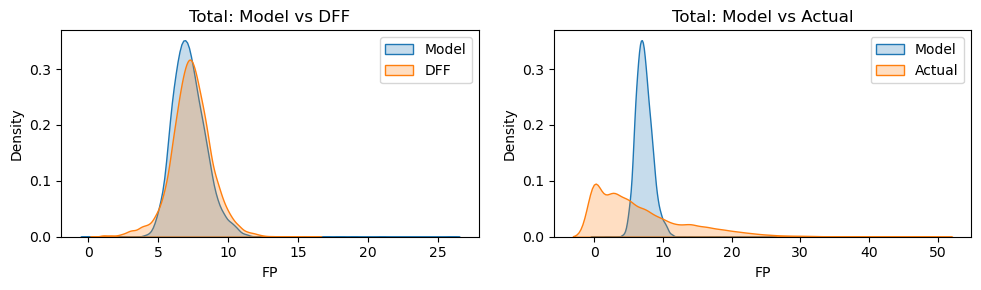

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))  # 1 row, 2 columns

# Left plot: Model vs DFF
sns.kdeplot(batters_with_dff['FP'], label='Model', shade=True, ax=axes[0])
sns.kdeplot(batters_with_dff['FP_DFF'], label='DFF', shade=True, ax=axes[0])
axes[0].legend()
axes[0].set_title("Total: Model vs DFF")

# Right plot: Model vs Actual
sns.kdeplot(batters_with_dff['FP'], label='Model', shade=True, ax=axes[1])
sns.kdeplot(batters_with_dff['fp'], label='Actual', shade=True, ax=axes[1])
axes[1].legend()
axes[1].set_title("Total: Model vs Actual")

plt.tight_layout()
plt.show()

##### Figure 2B. Batters over Time

In [46]:
# Step 1: Convert date column to datetime
batters_with_dff['date'] = pd.to_datetime(batters_with_dff['date'], format='%Y%m%d')

# Step 2: Create a Year-Month column
batters_with_dff['year_month'] = batters_with_dff['date'].dt.to_period('M')

# Step 3: Group by Year-Month and average the relevant columns
monthly_means = batters_with_dff.groupby('year_month')[
    ['FP', 'fp', 'FP_DFF']
].mean().reset_index()

# Step 4: Convert year_month back to datetime for plotting
monthly_means['year_month'] = monthly_means['year_month'].dt.to_timestamp()

Write to Excel

In [47]:
with pd.ExcelWriter(player_stat_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    monthly_means.to_excel(writer, sheet_name='BattersOverTime', index=False)

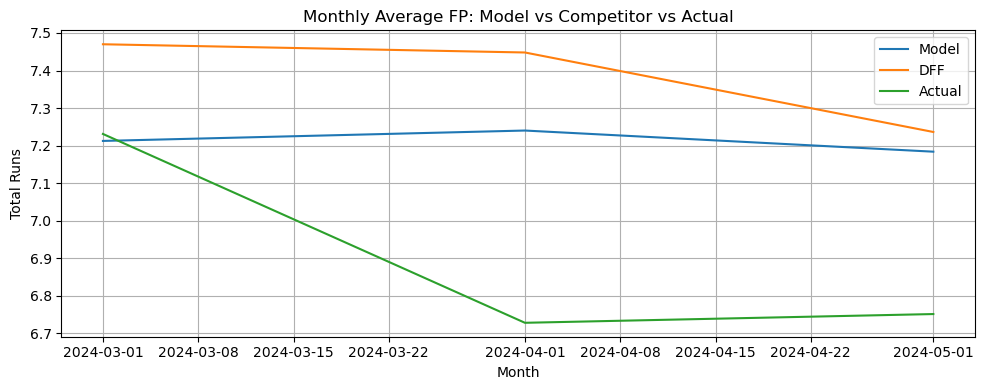

In [48]:
# Step 5: Plot
plt.figure(figsize=(10, 4))
plt.plot(monthly_means['year_month'], monthly_means['FP'], label='Model')
plt.plot(monthly_means['year_month'], monthly_means['FP_DFF'], label='DFF')
plt.plot(monthly_means['year_month'], monthly_means['fp'], label='Actual')

plt.title('Monthly Average FP: Model vs Competitor vs Actual')
plt.xlabel('Month')
plt.ylabel('Total Runs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

##### Figure 2C. Batters by Venue

In [49]:
batter_park_fp = batters_with_dff.query('battingSpotInstance == 1').groupby('venue_id')[['FP', 'FP_DFF', 'fp']].agg(['mean']).reset_index()
batter_park_fp.columns = ['VENUE_ID', 'FP', 'FP_DFF', 'fp']
batter_park_fp = pd.merge(batter_park_fp, venue_map_df[['id', 'name']], left_on='VENUE_ID', right_on='id', how='left')

batter_park_fp.rename(columns={'FP': 'Model',
                               'FP_DFF': 'DFF',
                               'fp': 'Actual'}, inplace=True)

batter_park_fp = batter_park_fp[['VENUE_ID', 'name', 'Model', 'DFF', 'Actual']]

batter_park_fp = batter_park_fp[batter_park_fp['VENUE_ID'].isin(team_map['VENUE_ID'].unique())]
batter_park_fp

,VENUE_ID,name,Model,DFF,Actual
0,1,Angel Stadium,7.310176,7.378262,8.422652
1,2,Oriole Park at Camden Yards,7.407490,7.434396,7.138350
2,3,Fenway Park,7.214006,7.685166,6.808140
3,4,Rate Field,6.948564,7.304601,6.991202
4,5,Progressive Field,7.279922,7.393272,7.083582
5,7,Kauffman Stadium,7.834872,7.577246,6.911695
6,10,Oakland Coliseum,7.195261,7.143322,7.081159
7,12,Tropicana Field,6.310893,7.195028,7.454148
8,14,Rogers Centre,7.122178,7.325590,6.823056
9,15,Chase Field,7.983341,7.707400,7.303896


Write to Excel

In [50]:
with pd.ExcelWriter(player_stat_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    batter_park_fp.to_excel(writer, sheet_name='BattersByVenue', index=False)

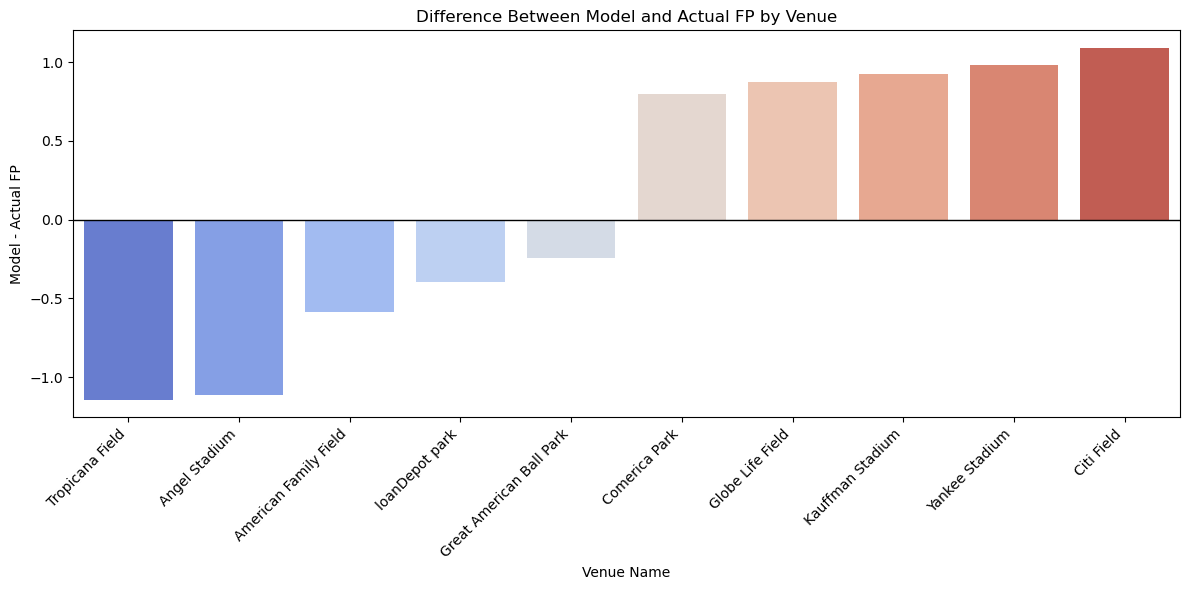

In [51]:
# Step 3: Compute the difference
batter_park_fp['Diff'] = batter_park_fp['Model'] - batter_park_fp['Actual']

# Step 4: Get top and bottom 5
sorted_batter_park_fp = batter_park_fp.sort_values('Diff')
top_bottom = pd.concat([sorted_batter_park_fp.head(5), sorted_batter_park_fp.tail(5)])

# Step 5: Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=top_bottom, x='name', y='Diff', palette='coolwarm')
plt.axhline(0, color='black', linewidth=1)
plt.title('Difference Between Model and Actual FP by Venue')
plt.ylabel('Model - Actual FP')
plt.xlabel('Venue Name')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

##### Pitchers

Merge DFF projections onto my projections

In [52]:
pitchers_with_dff = pitchers_merged_df.drop_duplicates(['fullName', 'date']).merge(dff_df, on=['fullName', 'date'], how='inner')

Create error and success measures

In [53]:
pitchers_with_dff['error_me'] = (pitchers_with_dff['fp'] - pitchers_with_dff['FP'])
pitchers_with_dff['error_dff'] = (pitchers_with_dff['fp'] - pitchers_with_dff['FP_DFF'])

pitchers_with_dff['error_me2'] = pitchers_with_dff['error_me'] ** 2
pitchers_with_dff['error_dff2'] = pitchers_with_dff['error_dff'] ** 2

pitchers_with_dff['beat_dff'] = (pitchers_with_dff['error_me2'] < pitchers_with_dff['error_dff2']).astype('int')

##### Figure 2D. Pitcher FP

In [54]:
pitcher_summary_stats = pitchers_with_dff.dropna().query('starter == 1')[['FP', 'FP_DFF', 'fp', 'error_me', 'error_dff', 'error_me2', 'error_dff2', 'beat_dff']].describe(percentiles=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
pitcher_summary_stats

,FP,FP_DFF,fp,error_me,error_dff,error_me2,error_dff2,beat_dff
count,1468.000000,1468.000000,1468.000000,1468.000000,1468.000000,1468.000000,1468.000000,1468.000000
mean,13.899544,13.759360,14.264237,0.364693,0.504877,101.222840,103.648918,0.506812
std,3.622281,3.351133,10.697851,10.057771,10.171750,140.803206,145.697586,0.500124
min,5.754117,2.232000,-23.700000,-35.268849,-37.875000,0.000194,0.000049,0.000000
10%,9.537485,9.622600,0.620000,-12.448185,-12.656600,1.828850,1.705155,0.000000
20%,10.813393,11.084000,4.720000,-8.214415,-8.250000,7.894002,8.979631,0.000000
30%,11.736424,12.123400,8.510000,-5.157912,-4.772000,17.532373,17.276512,0.000000
40%,12.736766,13.067000,11.240000,-2.077728,-2.071000,32.133960,31.248100,0.000000
50%,13.635144,13.929000,14.275000,0.775868,0.796000,50.266863,48.958058,1.000000
60%,14.532520,14.694600,17.550000,3.356220,3.831200,71.195123,76.849770,1.000000


Write to Excel

In [55]:
with pd.ExcelWriter(player_stat_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    pitcher_summary_stats.to_excel(writer, sheet_name='PitcherFP', index=True)

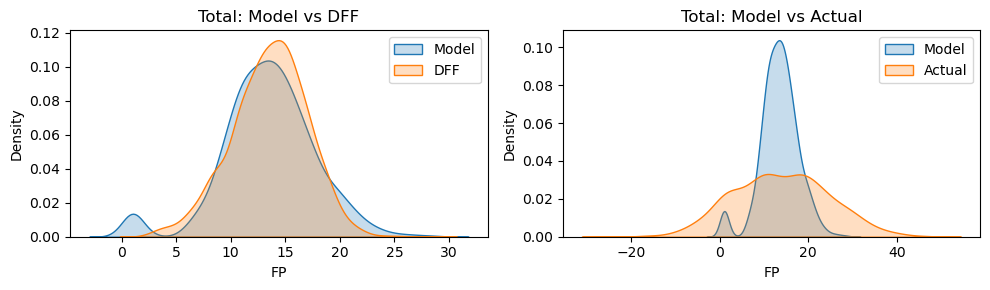

In [56]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))  # 1 row, 2 columns

# Left plot: Model vs DFF
sns.kdeplot(pitchers_with_dff['FP'], label='Model', shade=True, ax=axes[0])
sns.kdeplot(pitchers_with_dff['FP_DFF'], label='DFF', shade=True, ax=axes[0])
axes[0].legend()
axes[0].set_title("Total: Model vs DFF")

# Right plot: Model vs Actual
sns.kdeplot(pitchers_with_dff['FP'], label='Model', shade=True, ax=axes[1])
sns.kdeplot(pitchers_with_dff['fp'], label='Actual', shade=True, ax=axes[1])
axes[1].legend()
axes[1].set_title("Total: Model vs Actual")

plt.tight_layout()
plt.show()

##### Figure 2E. Pitchers over Time

In [57]:
# Step 1: Convert date column to datetime
pitchers_with_dff['date'] = pd.to_datetime(pitchers_with_dff['date'], format='%Y%m%d')

# Step 2: Create a Year-Month column
pitchers_with_dff['year_month'] = pitchers_with_dff['date'].dt.to_period('M')

# Step 3: Group by Year-Month and average the relevant columns
monthly_means = pitchers_with_dff.groupby('year_month')[
    ['FP', 'fp', 'FP_DFF']
].mean().reset_index()

# Step 4: Convert year_month back to datetime for plotting
monthly_means['year_month'] = monthly_means['year_month'].dt.to_timestamp()

Write to Excel

In [58]:
with pd.ExcelWriter(player_stat_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    monthly_means.to_excel(writer, sheet_name='PitchersOverTime', index=False)

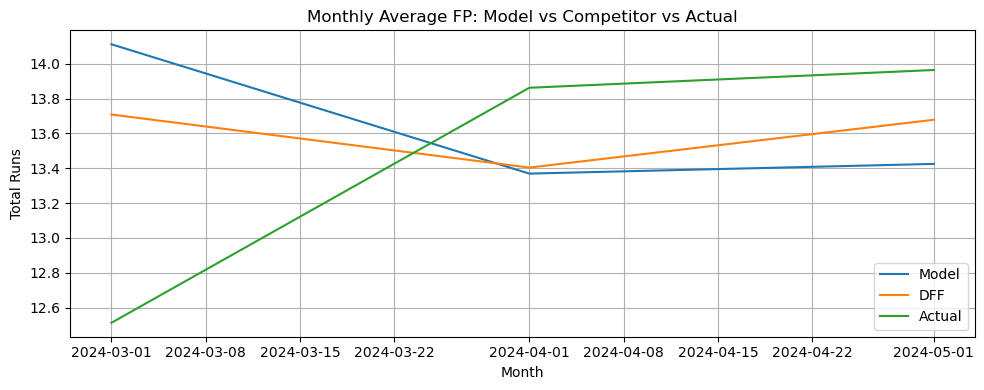

In [59]:
# Step 5: Plot
plt.figure(figsize=(10, 4))
plt.plot(monthly_means['year_month'], monthly_means['FP'], label='Model')
plt.plot(monthly_means['year_month'], monthly_means['FP_DFF'], label='DFF')
plt.plot(monthly_means['year_month'], monthly_means['fp'], label='Actual')

plt.title('Monthly Average FP: Model vs Competitor vs Actual')
plt.xlabel('Month')
plt.ylabel('Total Runs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

##### Figure 2F. Pitchers by Venue

In [60]:
pitcher_park_fp = pitchers_with_dff.query('starter == 1').groupby('venue_id')[['FP', 'FP_DFF', 'fp']].agg(['mean']).reset_index()
pitcher_park_fp.columns = ['VENUE_ID', 'FP', 'FP_DFF', 'fp']
pitcher_park_fp = pd.merge(pitcher_park_fp, venue_map_df[['id', 'name']], left_on='VENUE_ID', right_on='id', how='left')

pitcher_park_fp.rename(columns={'FP': 'Model',
                               'FP_DFF': 'DFF',
                               'fp': 'Actual'}, inplace=True)

pitcher_park_fp = pitcher_park_fp[['VENUE_ID', 'name', 'Model', 'DFF', 'Actual']]

pitcher_park_fp = pitcher_park_fp[pitcher_park_fp['VENUE_ID'].isin(team_map['VENUE_ID'].unique())]
    
pitcher_park_fp

,VENUE_ID,name,Model,DFF,Actual
0,1.000000,Angel Stadium,14.801665,14.526239,13.810870
1,2.000000,Oriole Park at Camden Yards,14.004258,15.180673,13.975962
2,3.000000,Fenway Park,14.730021,13.210848,14.257609
3,4.000000,Rate Field,14.147018,13.436022,14.536667
4,5.000000,Progressive Field,12.687056,12.632795,12.103409
5,7.000000,Kauffman Stadium,11.506691,13.641140,13.471930
6,10.000000,Oakland Coliseum,13.453490,13.240260,13.167000
7,12.000000,Tropicana Field,16.838026,13.937464,15.048214
8,14.000000,Rogers Centre,13.846492,14.208565,15.410870
9,15.000000,Chase Field,11.345649,13.145353,11.214706


Write to Excel

In [61]:
with pd.ExcelWriter(player_stat_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    pitcher_park_fp.to_excel(writer, sheet_name='PitchersByVenue', index=False)

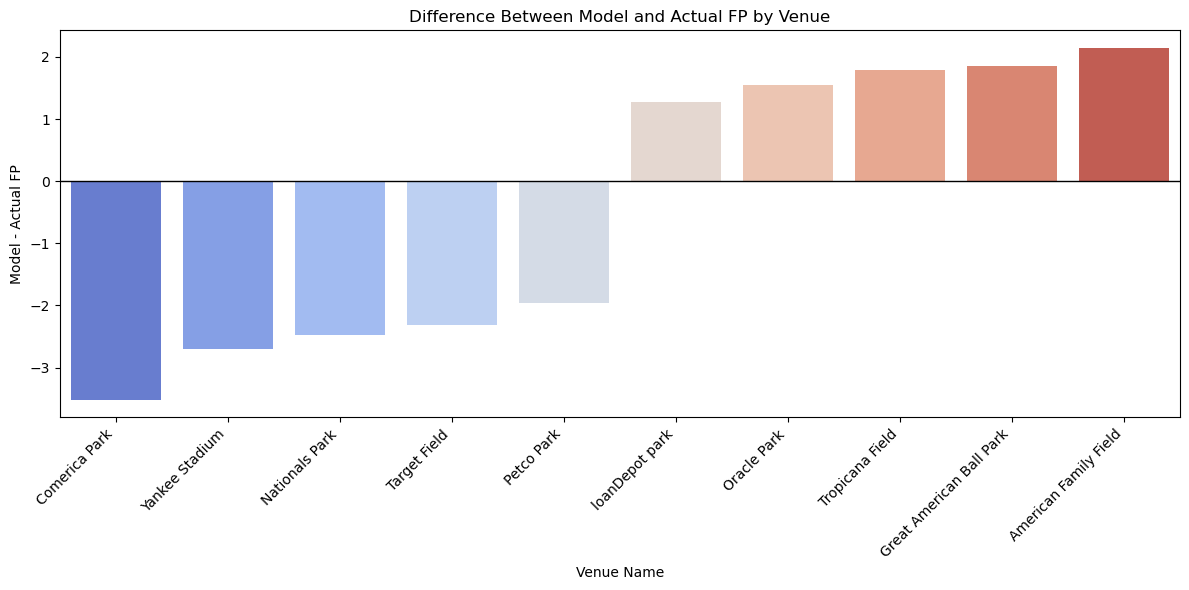

In [62]:
# Compute the difference
pitcher_park_fp['Diff'] = pitcher_park_fp['Model'] - pitcher_park_fp['Actual']

# Get top and bottom 5
pitcher_park_fp = pitcher_park_fp.sort_values('Diff')
top_bottom = pd.concat([pitcher_park_fp.head(5), pitcher_park_fp.tail(5)])

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=top_bottom, x='name', y='Diff', palette='coolwarm')
plt.axhline(0, color='black', linewidth=1)
plt.title('Difference Between Model and Actual FP by Venue')
plt.ylabel('Model - Actual FP')
plt.xlabel('Venue Name')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [63]:
!jupyter nbconvert --to html "E02. Evaluate Players.ipynb" \
  --output="E02. Evaluate Players {datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.html" \
  --output-dir="{os.path.join(baseball_path, 'E02. Evaluate Players')}"

[NbConvertApp] Converting notebook E02. Evaluate Players.ipynb to html
[NbConvertApp] Writing 541694 bytes to C:\Users\james\Documents\MLB\Database\E02. Evaluate Players\E02. Evaluate Players 2025-09-24_09-23-07.html
